# 2️⃣ PyCaret Classification: Predicting Survival on the Titanic
Classification is a Supervised Learning task where the goal is to predict **categorical labels** (discrete classes). 
In this notebook, we aim to predict whether a passenger survived (`1`) or not (`0`).

## Key Learning Objectives:
1. **Automated Preprocessing**: Handling categorical variables like 'Sex' and 'Embarked'.
2. **Model Leaderboard**: Comparing classifiers (Random Forest, XGBoost, CatBoost, etc.).
3. **Performance Metrics**: Analyzing Accuracy, AUC, Precision, and Recall.
4. **Model Deployment**: Exporting and re-loading the classification pipeline.

## Environment Preparation

In [ ]:
%%capture
# !pip install pycaret

In [13]:
import pandas as pd
from pycaret.classification import *
import os

# Create Output folder
output_dir = './Output'
if not os.path.exists(output_dir): os.makedirs(output_dir)

## 1. Initializing the Experiment
PyCaret's `setup()` function automatically detects feature types and handles missing values (Imputation).

In [14]:
df = pd.read_csv('./Data/Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
# Initialize setup
# target: 'Survived' (0 = No, 1 = Yes)
# session_id: For reproducibility
# fix_imbalance: Useful if one class has much fewer samples than the other
clf_setup = setup(data=df, target='Survived', session_id=42, verbose=False)

print("✅ Classification Setup Complete: Pipeline is ready.")

✅ Classification Setup Complete: Pipeline is ready.


In [16]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


## 2. Comparing and Fine-Tuning Models
We compare all available classifiers and then use `tune_model()` to optimize the **F1-Score**, which balances Precision and Recall.

In [17]:
# Compare all models and return the best one based on Accuracy
best_clf_model = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:21:54
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8252,0.8677,0.6993,0.8246,0.7533,0.6199,0.6278,0.9510
ridge,Ridge Classifier,0.7578,0.8663,0.4486,0.8566,0.5838,0.4372,0.4849,0.0250
et,Extra Trees Classifier,0.6984,0.8078,0.2806,0.8062,0.4128,0.2719,0.3406,0.0550
nb,Naive Bayes,0.6711,0.8168,0.1882,0.8236,0.3008,0.1859,0.2740,0.0290
knn,K Neighbors Classifier,0.6307,0.6070,0.3433,0.5368,0.4132,0.1644,0.1753,0.4050
lda,Linear Discriminant Analysis,0.6293,0.5423,0.0391,0.0900,0.0545,0.0414,0.0480,0.0190
rf,Random Forest Classifier,0.6292,0.8531,0.0422,0.5000,0.0772,0.0449,0.1002,0.0620
dt,Decision Tree Classifier,0.6164,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200
ada,Ada Boost Classifier,0.6164,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200
gbc,Gradient Boosting Classifier,0.6164,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0350


In [18]:
# Fine-tune the best model to optimize for balanced performance
tuned_clf_model = tune_model(best_clf_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7937,0.8654,0.7083,0.7391,0.7234,0.5590,0.5593
1,0.7937,0.8910,0.6667,0.7619,0.7111,0.5517,0.5547
2,0.7778,0.8397,0.6250,0.7500,0.6818,0.5132,0.5183
3,0.9355,0.9420,0.8261,1.0000,0.9048,0.8566,0.8656
4,0.8710,0.8553,0.6667,1.0000,0.8000,0.7103,0.7421
5,0.9032,0.9243,0.7917,0.9500,0.8636,0.7896,0.7975
6,0.8065,0.9035,0.5833,0.8750,0.7000,0.5654,0.5908
7,0.8065,0.8257,0.5833,0.8750,0.7000,0.5654,0.5908
8,0.8710,0.8618,0.7500,0.9000,0.8182,0.7195,0.7266


Fitting 10 folds for each of 10 candidates, totalling 100 fits


## 3. Visual Analysis & Performance Metrics
In Classification, we use the **Confusion Matrix** to see exactly where the model is making mistakes.
- **True Positives**: Correctly predicted survivors.
- **False Positives**: Passengers predicted to survive who unfortunately didn't.

In [19]:
# Open the interactive evaluation dashboard
evaluate_model(tuned_clf_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

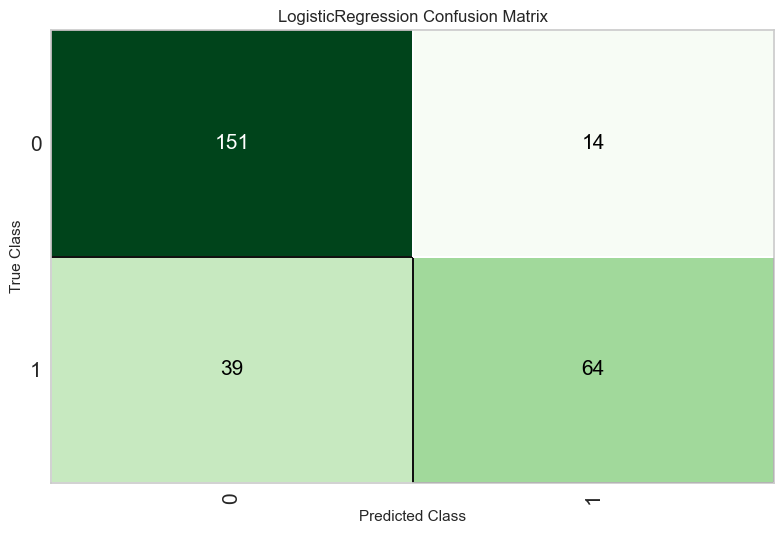

In [20]:
# Specifically plot the Confusion Matrix
plot_model(tuned_clf_model, plot='confusion_matrix')

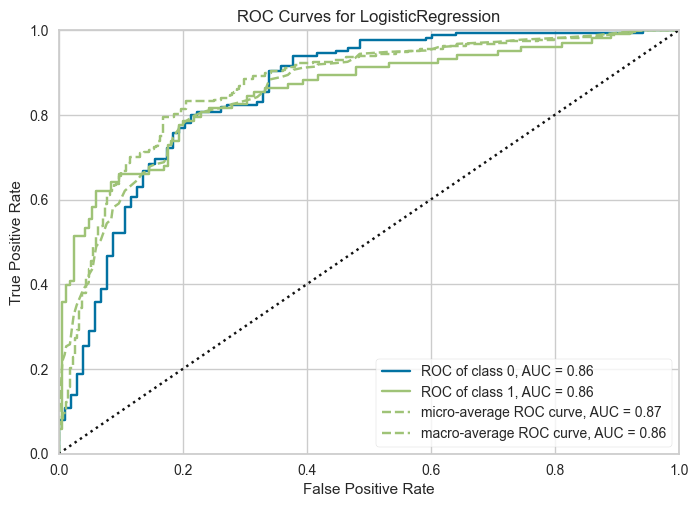

In [25]:
# Specifically plot the ROC Curve
plot_model(tuned_clf_model, plot='auc')

## 4. Finalizing the Model
We check the performance on the test set and then finalize the model for production.

In [21]:
# Predict on hold-out/test data
classification_results = predict_model(tuned_clf_model)

# Finalize the model (train on 100% of data)
final_titanic_model = finalize_model(tuned_clf_model)

print("--- Sample Predictions (Survived vs. Prediction_Label) ---")
print(classification_results[['Survived', 'prediction_label', 'prediction_score']].head())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8022,0.8552,0.6214,0.8205,0.7072,0.5621,0.5745


--- Sample Predictions (Survived vs. Prediction_Label) ---
     Survived  prediction_label  prediction_score
625         0                 0            0.7720
566         0                 0            0.8197
459         0                 0            0.8019
804         1                 0            0.8476
338         1                 0            0.9082


## 5. Model Export and Re-use
We save the classification pipeline as a `.pkl` file to use it in future applications.

In [22]:
# Save the model
clf_save_path = os.path.join(output_dir, 'classification_titanic_survival_model')
save_model(final_titanic_model, clf_save_path)

# --- RE-LOADING THE MODEL ---
# Load the saved pipeline
loaded_survival_model = load_model(clf_save_path)

# Predict on new data (first 5 rows for demo)
new_passengers = df.head(5)
final_preds = predict_model(loaded_survival_model, data=new_passengers)

print("\n✅ Predictions from LOADED Classification model:")
print(final_preds[['prediction_label', 'prediction_score']])

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000



✅ Predictions from LOADED Classification model:
   prediction_label  prediction_score
0                 0            0.9643
1                 1            0.9707
2                 1            0.9140
3                 1            0.9168
4                 0            0.9697
